In [1]:
import numpy as np
import os, sys
import galsim as gs
from galsim.angle import Angle, radians
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
import transformation as transform
import likelihood, cube, priors, utils, basis, parameters
from muse import MuseDataCube

plt.rcParams['axes.facecolor'] = 'w'

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [25]:
sampled_pars = [
        'g1',
        'g2',
        'theta_int',
        'sini',
        'v0',
        'vcirc',
        'rscale',
        'beta'
        ]

    # additional args needed for prior / likelihood evaluation
meta_pars = {
    'units': {
        'v_unit': u.Unit('km/s'),
        'r_unit': u.Unit('kpc')
        },
    'priors': {
        'g1': priors.GaussPrior(0., 0.3, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.3, clip_sigmas=2),
        # 'theta_int': priors.UniformPrior(0., np.pi),
        'theta_int': priors.UniformPrior(0., np.pi),
        # 'theta_int': priors.UniformPrior(np.pi/3, np.pi),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.UniformPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 20, zero_boundary='positive'),# clip_sigmas=2),
        # 'vcirc': priors.GaussPrior(188, 2.5, zero_boundary='positive', clip_sigmas=2),
        # 'vcirc': priors.UniformPrior(190, 210),
        'rscale': priors.UniformPrior(0, 20),
        'beta': priors.UniformPrior(0, .2),
        # 'hlr': priors.UniformPrior(0, 8),
        # 'flux': priors.UniformPrior(5e3, 7e4),
        },
        # 'marginalize_intensity': True,
#         'psf': gs.Moffat(fwhm=0.8, beta=2.5), # fwhm in pixels
    'psf': gs.Gaussian(fwhm=0.7, flux=1.),
    'run_options': {
        'use_numba': False
        }
}

pars_shapelet = meta_pars.copy()
pars_sersiclet = meta_pars.copy()
pars_exp_shapelet = meta_pars.copy()

nmax_cart  = 10
nmax_polar = 7
beta_shapelet = 2.8
beta_sersiclet = 5
pars_shapelet['intensity'] = {
    'type': 'basis',
    'basis_type': 'shapelets',
    'basis_kwargs': {
        'Nmax': nmax_cart,
        'beta': 3.26,
    }
}
pars_sersiclet['intensity'] = {
    'type': 'basis',
    'basis_type': 'sersiclets',
    'basis_kwargs': {
        'Nmax': nmax_polar,
        'beta': 7.29,
        'index': 1,
        'b': 1,
    }
}
pars_exp_shapelet['intensity'] = {
    'type': 'basis',
    'basis_type': 'exp_shapelets',
    'basis_kwargs': {
        'Nmax': nmax_polar,
        'beta': 0.08,
    }
}

plane = 'obs'
for p in [pars_shapelet, pars_sersiclet, pars_exp_shapelet]:
    p['intensity']['basis_kwargs']['plane'] = plane
    
# sampled_pars = list(true_pars)
Pars = parameters.Pars(sampled_pars, meta_pars)
pars_shapelet = parameters.MCMCPars(pars_shapelet)
pars_sersiclet = parameters.MCMCPars(pars_sersiclet)
pars_exp_shapelet = parameters.MCMCPars(pars_exp_shapelet)

# Setup MUSE DataCube
cube_dir = os.path.join(utils.TEST_DIR, 'test_data')

cubefile = os.path.join(cube_dir, '102021103_objcube.fits')
specfile = os.path.join(cube_dir, 'spectrum_102021103.fits')
catfile = os.path.join(cube_dir, 'MW_1-24_main_table.fits')
linefile = os.path.join(cube_dir, 'MW_1-24_emline_table.fits')

In [9]:
# datacube, sed, vmap, true_im = likelihood.setup_likelihood_test(
#     true_pars, pars, shape, lambdas
#     )

print(f'Setting up MUSE datacube from file {cubefile}')
datacube = MuseDataCube(
    cubefile, specfile, catfile, linefile
    )

# default, but we'll make it explicit:
datacube.set_line(line_choice='strongest')
Nspec = datacube.Nspec
lambdas = datacube.lambdas

datacube.set_psf(meta_pars['psf'])

Setting up MUSE datacube from file /Users/sweveret/repos/kl-tools/tests/test_data/102021103_objcube.fits


In [10]:
def make_basis_imap(theta_pars, datacube, pars):
    imap = likelihood.DataCubeLikelihood._setup_imap(theta_pars, datacube, pars)
    i = imap.render(theta_pars, datacube, pars)
#     marg = imap.fitter.compute_marginalization_det(pars=pars, log=True)
    marg = None
    mle = imap.fitter.mle_coefficients
    
    return i, marg, mle, imap

In [7]:
shapelet, marg_shapelet, mle_shapelet, imap_shapelet = make_basis_imap(true_pars, datacube, pars_shapelet)
sersiclet, marg_sersiclet, mle_sersiclet, imap_sersiclet = make_basis_imap(true_pars, datacube, pars_sersiclet)
exp_shapelet, marg_exp_shapelet, mle_exp_shapelet, imap_exp_shapelet = make_basis_imap(true_pars, datacube, pars_exp_shapelet)

NameError: name 'true_pars' is not defined

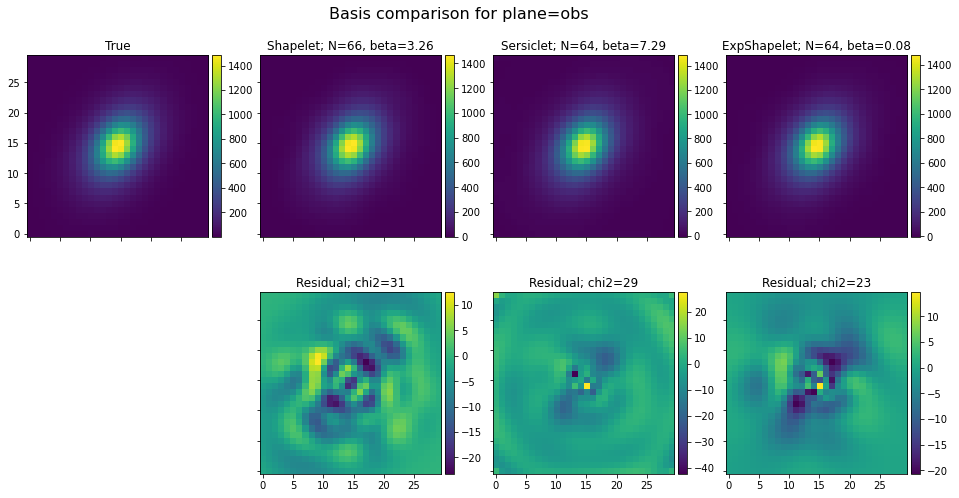

In [6]:
plt.rcParams.update({'font.size': 10})

s = (16, 8)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                         facecolor='w', figsize=s)

images = [true_im, shapelet, sersiclet, exp_shapelet,
          None, shapelet-true_im, sersiclet-true_im, exp_shapelet-true_im]

titles = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
          None, 'Residual', 'Residual', 'Residual']

names = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
        None, 'Shapelet', 'Sersiclet', 'ExpShapelet']

Nfuncs = {
    'Shapelet': len(mle_shapelet),
    'Sersiclet': len(mle_sersiclet),
    'ExpShapelet': len(mle_exp_shapelet)
}

chi2 = {
    'Shapelet': np.sum((shapelet-true_im)**2) / (Nx*Ny),
    'Sersiclet': np.sum((sersiclet-true_im)**2) / (Nx*Ny),
    'ExpShapelet': np.sum((exp_shapelet-true_im)**2) / (Nx*Ny),
}

beta = {
    'Shapelet': imap_shapelet.fitter.basis.beta,
    'Sersiclet': imap_sersiclet.fitter.basis.beta,
    'ExpShapelet': imap_exp_shapelet.fitter.basis.beta,
}

for i in range(nrows*ncols):
    ax = axes[i//ncols, i%ncols]
    if (i//ncols == 1) and (i%ncols == 0):
        ax.axis('off')
        continue
    im = ax.imshow(images[i], origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    
    if i//ncols == 1:
        c = chi2[names[i]]
    else:
        c = 0
    
    if (i//ncols == 0) and (i%ncols != 0):
        extra = f'; N={Nfuncs[titles[i]]}, beta={beta[names[i]]:.2f}'
    elif (i//ncols == 1):
        extra = f'; chi2={c:.0f}'
    else:
        extra = ''
    ax.set_title(titles[i]+extra)
    
plt.suptitle(f'Basis comparison for plane={plane}', y=0.95, fontsize=16)
plt.show()

## Visualize profiles

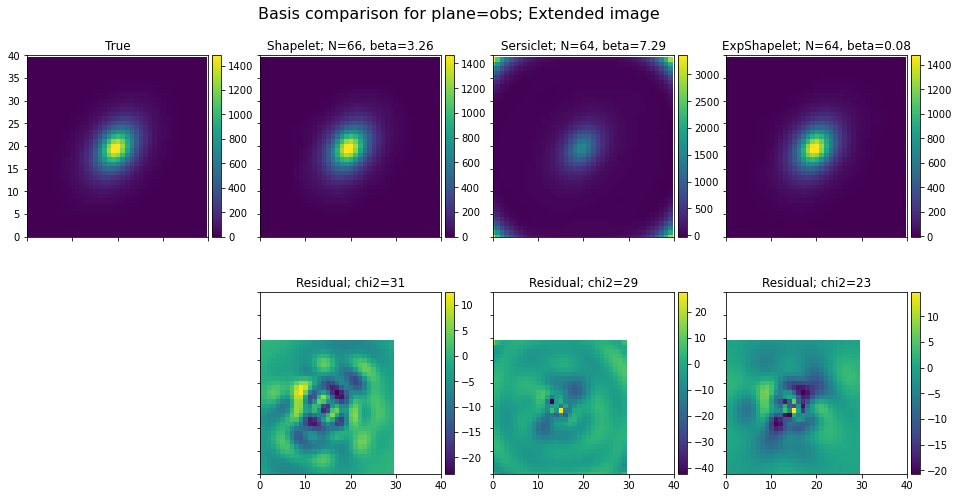

In [7]:
Nfuncs = {
    'Shapelet': len(mle_shapelet),
    'Sersiclet': len(mle_sersiclet),
    'ExpShapelet': len(mle_exp_shapelet)
}

imaps = {
    'Shapelet': imap_shapelet,
    'Sersiclet': imap_sersiclet,
    'ExpShapelet': imap_exp_shapelet
}

coefficients = {
    'Shapelet': mle_shapelet,
    'Sersiclet': mle_sersiclet,
    'ExpShapelet': mle_exp_shapelet
}

beta = {
    'Shapelet': imap_shapelet.fitter.basis.beta,
    'Sersiclet': imap_sersiclet.fitter.basis.beta,
    'ExpShapelet': imap_exp_shapelet.fitter.basis.beta,
}

titles = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
          None, 'Residual', 'Residual', 'Residual']

names = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
        None, 'Shapelet', 'Sersiclet', 'ExpShapelet']

im_shape = (40,40)

cmap = None

true_im_big = np.zeros(im_shape)

diff_x = im_shape[0]-Nx
diff_y = im_shape[1]-Ny
start_x = diff_x//2
start_y = diff_y//2
true_im_big[start_x:start_x+Nx, start_y:start_y+Ny] = true_im
        
images = [true_im, shapelet, sersiclet, exp_shapelet,
          None, shapelet-true_im, sersiclet-true_im, exp_shapelet-true_im]

plt.rcParams.update({'font.size': 10})

s = (16, 8)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                         facecolor='w', figsize=s)

# for name, nfuncs in Nfuncs.items():

for i in range(nrows*ncols):
    ax = axes[i//ncols, i%ncols]
    if (i//ncols == 1) and (i%ncols == 0):
        ax.axis('off')
        continue
        
    if i == 0:
        im = ax.imshow(true_im_big, origin='lower', cmap=cmap)
        ax.set_title(titles[i])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(im, cax=cax)
        continue
        
    name = names[i]
    coeff = coefficients[name]
    
    if i//ncols==0:
        im = ax.imshow(
            imaps[name].fitter.basis.render_im(true_pars, coeff, im_shape=im_shape),
            origin='lower',
            cmap=cmap)
    else:
        im = ax.imshow(images[i], origin='lower', cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    
    ax.set_xlim(0, im_shape[0])
    ax.set_ylim(0, im_shape[1])
    
    if i//ncols == 1:
        c = chi2[names[i]]
    else:
        c = 0
    
    if (i//ncols == 0) and (i%ncols != 0):
        extra = f'; N={Nfuncs[titles[i]]}, beta={beta[names[i]]:.2f}'
    elif (i//ncols == 1):
        extra = f'; chi2={c:.0f}'
    else:
        extra = ''
    ax.set_title(titles[i]+extra)
    
plt.suptitle(f'Basis comparison for plane={plane}; Extended image', y=0.95, fontsize=16)
plt.show()

0 of 100
25 of 100
50 of 100
75 of 100


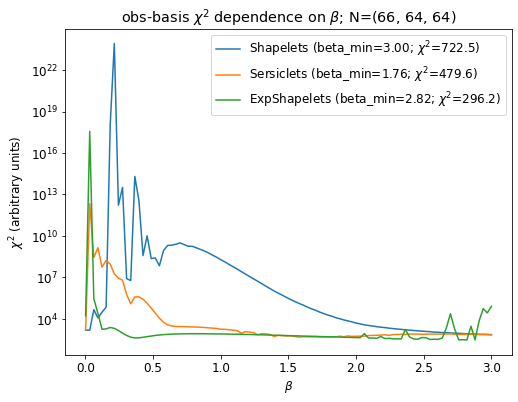

In [33]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.facecolor'] = 'w'

from copy import deepcopy

pars_shapelet_b = deepcopy(pars_shapelet)
pars_sersiclet_b = deepcopy(pars_sersiclet)
pars_exp_shapelet_b = deepcopy(pars_exp_shapelet)

fwhm = 0.4
psf = gs.Gaussian(fwhm=fwhm, flux=1.)
pars_shapelet_b.pars.update({'psf':psf})
pars_sersiclet_b.pars.update({'psf':psf})
pars_exp_shapelet_b.pars.update({'psf':psf})

# fake true_pars to make it work:
true_pars = {
    'g1': 0.75,
    'g2': -0.025,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 700,
    'rscale': 5,
}

true_im = datacube.stack()
Nx, Ny = datacube.Nx, datacube.Ny

Nbetas = 100
betas = np.linspace(0.001, 3, Nbetas)

shapelet_chi2 = np.zeros(Nbetas)
sersiclet_chi2 = np.zeros(Nbetas)
exp_shapelet_chi2 = np.zeros(Nbetas)

fig = plt.plot(facecolor='w')

for i, beta in enumerate(betas):
    if (i%25) == 0:
        print(f'{i} of {len(betas)}')
        
    pars_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_sersiclet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_exp_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    
    shapelet, _, shapelet_mle = make_basis_imap(true_pars, datacube, pars_shapelet_b)[0:3]
    sersiclet, _, sersiclet_mle = make_basis_imap(true_pars, datacube, pars_sersiclet_b)[0:3]
    exp_shapelet, _, exp_shapelet_mle = make_basis_imap(true_pars, datacube, pars_exp_shapelet_b)[0:3]
    
    shapelet_chi2[i] = np.sum((shapelet-true_im)**2 / (Nx*Ny))
    sersiclet_chi2[i] = np.sum((sersiclet-true_im)**2 / (Nx*Ny))
    exp_shapelet_chi2[i] = np.sum((exp_shapelet-true_im)**2 / (Nx*Ny))
    
shapelet_min = betas[np.argmin(shapelet_chi2)]
sersiclet_min = betas[np.argmin(sersiclet_chi2)]
exp_shapelet_min = betas[np.argmin(exp_shapelet_chi2)]

shapelet_min_chi2 = np.min(shapelet_chi2)
sersiclet_min_chi2 = np.min(sersiclet_chi2)
exp_shapelet_min_chi2 = np.min(exp_shapelet_chi2)

# fig, axes = plt.subplots(111, facecolor='w', figsize=(8,6))
    
# ax = axes[0]
plt.plot(betas, shapelet_chi2, label=f'Shapelets (beta_min={shapelet_min:.2f}; $\chi^2$={shapelet_min_chi2:.1f})')
plt.plot(betas, sersiclet_chi2, label=f'Sersiclets (beta_min={sersiclet_min:.2f}; $\chi^2$={sersiclet_min_chi2:.1f})')
plt.plot(betas, exp_shapelet_chi2, label=f'ExpShapelets (beta_min={exp_shapelet_min:.2f}; $\chi^2$={exp_shapelet_min_chi2:.1f})')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^2$ (arbitrary units)')      
plt.yscale('log')
plt.axhline(0, lw=2, c='k')

nfuncs = (len(shapelet_mle), len(sersiclet_mle), len(exp_shapelet_mle))
plt.title(rf'{plane}-basis $\chi^2$ dependence on $\beta$; N={nfuncs}')

plt.gcf().patch.set_facecolor('w')
plt.gcf().set_size_inches(8,6)

In [41]:
pars_shapelet_b['psf'].fwhm

0.4

In [46]:
fwhm=10
psf = gs.Gaussian(fwhm=fwhm, flux=1.)
pars_shapelet_b.pars.update({'psf':psf})
pars_sersiclet_b.pars.update({'psf':psf})
pars_exp_shapelet_b.pars.update({'psf':psf})

pars_shapelet_b['intensity']['basis_kwargs']['beta'] = 3
pars_sersiclet_b['intensity']['basis_kwargs']['beta'] = 1.78
pars_exp_shapelet_b['intensity']['basis_kwargs']['beta'] = 1.5
    
shapelet, _, shapelet_mle = make_basis_imap(true_pars, datacube, pars_shapelet_b)[0:3]
sersiclet, _, sersiclet_mle = make_basis_imap(true_pars, datacube, pars_sersiclet_b)[0:3]
exp_shapelet, _, exp_shapelet_mle = make_basis_imap(true_pars, datacube, pars_exp_shapelet_b)[0:3]

psfs:
10.0
10.0
10.0


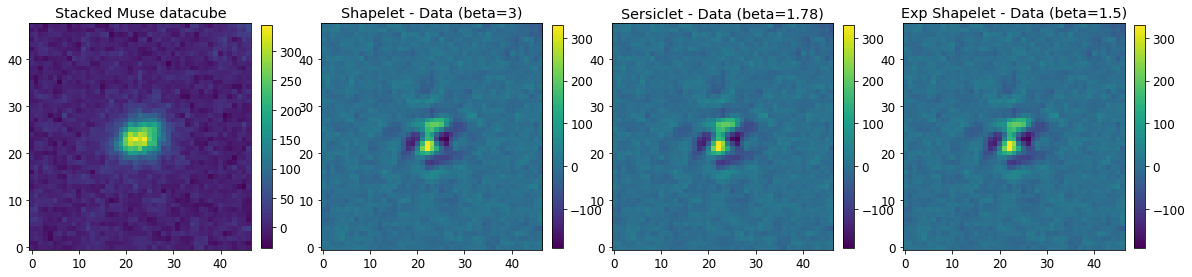

In [47]:
plt.rcParams.update({'figure.facecolor':'w'})

shapelet_beta = pars_shapelet_b['intensity']['basis_kwargs']['beta']
sersiclet_beta = pars_sersiclet_b['intensity']['basis_kwargs']['beta']
exp_shapelet_beta = pars_exp_shapelet_b['intensity']['basis_kwargs']['beta']

print('psfs:')
print(pars_shapelet_b['psf'].fwhm)
print(pars_sersiclet_b['psf'].fwhm)
print(pars_exp_shapelet_b['psf'].fwhm)

plt.subplot(141)
plt.imshow(true_im, origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Stacked Muse datacube')

plt.subplot(142)
plt.imshow(shapelet-true_im, origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(f'Shapelet - Data (beta={shapelet_beta})')

plt.subplot(143)
plt.imshow(shapelet-true_im, origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(f'Sersiclet - Data (beta={sersiclet_beta})')
          
plt.subplot(144)
plt.imshow(shapelet-true_im, origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(f'Exp Shapelet - Data (beta={exp_shapelet_beta})')

plt.gcf().set_size_inches(20,5)

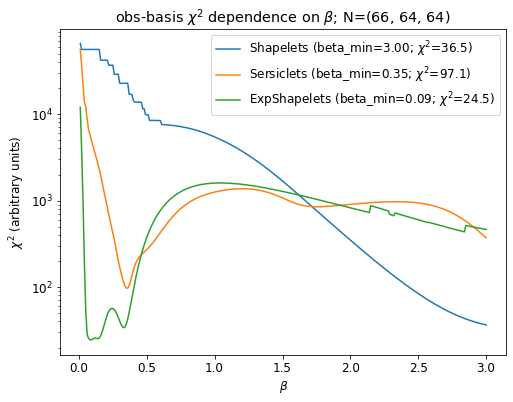

In [57]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.facecolor'] = 'w'

pars_shapelet_b = pars_shapelet.copy()
pars_sersiclet_b = pars_sersiclet.copy()
pars_exp_shapelet_b = pars_exp_shapelet.copy()


Nbetas = 300
betas = np.linspace(0.01, 3, Nbetas)

shapelet_chi2 = np.zeros(Nbetas)
sersiclet_chi2 = np.zeros(Nbetas)
exp_shapelet_chi2 = np.zeros(Nbetas)

fig = plt.plot(facecolor='w')

for i, beta in enumerate(betas):
    pars_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_sersiclet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_exp_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    
    shapelet, _, shapelet_mle = make_basis_imap(true_pars, datacube, pars_shapelet_b)[0:3]
    sersiclet, _, sersiclet_mle = make_basis_imap(true_pars, datacube, pars_sersiclet_b)[0:3]
    exp_shapelet, _, exp_shapelet_mle = make_basis_imap(true_pars, datacube, pars_exp_shapelet_b)[0:3]
    
    shapelet_chi2[i] = np.sum((shapelet-true_im)**2 / (Nx*Ny))
    sersiclet_chi2[i] = np.sum((sersiclet-true_im)**2 / (Nx*Ny))
    exp_shapelet_chi2[i] = np.sum((exp_shapelet-true_im)**2 / (Nx*Ny))
    
shapelet_min = betas[np.argmin(shapelet_chi2)]
sersiclet_min = betas[np.argmin(sersiclet_chi2)]
exp_shapelet_min = betas[np.argmin(exp_shapelet_chi2)]

shapelet_min_chi2 = np.min(shapelet_chi2)
sersiclet_min_chi2 = np.min(sersiclet_chi2)
exp_shapelet_min_chi2 = np.min(exp_shapelet_chi2)

# fig, axes = plt.subplots(111, facecolor='w', figsize=(8,6))
    
# ax = axes[0]
plt.plot(betas, shapelet_chi2, label=f'Shapelets (beta_min={shapelet_min:.2f}; $\chi^2$={shapelet_min_chi2:.1f})')
plt.plot(betas, sersiclet_chi2, label=f'Sersiclets (beta_min={sersiclet_min:.2f}; $\chi^2$={sersiclet_min_chi2:.1f})')
plt.plot(betas, exp_shapelet_chi2, label=f'ExpShapelets (beta_min={exp_shapelet_min:.2f}; $\chi^2$={exp_shapelet_min_chi2:.1f})')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^2$ (arbitrary units)')      
plt.yscale('log')
plt.axhline(0, lw=2, c='k')

nfuncs = (len(shapelet_mle), len(sersiclet_mle), len(exp_shapelet_mle))
plt.title(rf'{plane}-basis $\chi^2$ dependence on $\beta$; N={nfuncs}')

plt.gcf().patch.set_facecolor('w')
plt.gcf().set_size_inches(8,6)